In [58]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import random
from datetime import datetime

In [59]:
# Load the data
imgs_in = np.zeros((28,28,200))
imgs = np.zeros((8,8,200))
a = int(input("a: (0~9)"))
b = int(input("b: (0~9)"))
for i in range(100):
    imgs_in[:,:,i] = cv.imread("train1000/"+str(100*a+i+1)+".png",cv.IMREAD_GRAYSCALE)
    imgs_in[:,:,i+100] = cv.imread("train1000/"+str(100*b+i+1)+".png",cv.IMREAD_GRAYSCALE)
    imgs[:,:,i] = cv.resize(imgs_in[:,:,i], (8,8))
    imgs[:,:,i+100] = cv.resize(imgs_in[:,:,i+100], (8,8))

<function matplotlib.pyplot.show(close=None, block=None)>

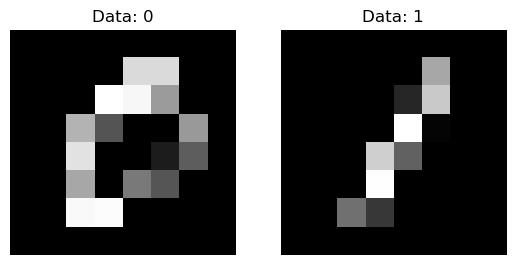

In [60]:
# Show input data
fig = plt.figure()
plt.subplot(121)
plt.axis('off')
plt.title("Data: " + str(a))
plt.imshow(imgs[:,:,0],"gray")
plt.subplot(122)
plt.axis('off')
plt.title("Data: " + str(b))
plt.imshow(imgs[:,:,100],"gray")
plt.show

In [61]:
# Create filter1 & filter2
filter1 = np.array([[-1, -1, 1], [-1, 0, 1], [-1, 1, 1]])
filter2 = filter1.T

In [62]:
# convolve2D
def convolve2D(image, kernel):
    kernel_size = kernel.shape[0]
    h ,w = image.shape

    image = np.pad(image, 1)
    new_image = np.zeros((h,w))

    for i in range(h):
        for j in range(w):
            new_image[i,j] = (image[i:i+kernel_size,j:j+kernel_size] * kernel).sum()

    return new_image

In [63]:
# max pooling
def max_pool(img):
    ds_img = np.zeros((img.shape[0]//2,img.shape[1]//2))

    for i in range(ds_img.shape[0]):
        for j in range(ds_img.shape[1]):
            ds_img[i,j]=img[2*i+0:2*i+2,2*j+0:2*j+2].max()
            
    return ds_img

In [64]:
# Feature extraction
output = np.zeros((9,200))

for i in range(200):

    # Leyer 1: Convolve2D
    conv1 = convolve2D(imgs[:,:,i],filter1)
    conv2 = convolve2D(conv1,filter2)
    # Leyer 1: Max pooling
    conv1 = max_pool(conv1)
    conv2= max_pool(conv2)
    featuremap = np.stack((conv1,conv2),axis=0)
    # Leyer 2: Convolve2D
    conv1 = convolve2D(featuremap[0],filter1)
    conv1 = convolve2D(conv1,filter2)
    conv2 = convolve2D(featuremap[1],filter1)
    conv2 = convolve2D(conv2,filter2)
    # Leyer 2: Max pooling
    conv1 = max_pool(conv1)
    conv2= max_pool(conv2)
    featuremap = np.stack((conv1,conv2),axis=0)
    # Flatten
    output[0:8,i] = featuremap.flatten()
    # Add bias
    output[8,i] = 1
    

In [65]:
# Create label
X = output.T
Y = np.concatenate((np.zeros((100,1)),np.ones((100,1))))

In [66]:
# Linear regression
A = (np.linalg.inv(X.T @ X)) @ X.T @ Y

In [67]:
# Prediction of Y
Yp = np.zeros((200,1))
Yp[X.dot(A) >= 0.5] = 1

# Ground Ture and Prediction with input values(a & b)
GT = np.zeros((200,1))
Pred = np.zeros((200,1))

GT[Y == 0 ] = a
GT[Y == 1 ] = b

Pred[Yp == 0 ] = a
Pred[Yp == 1 ] = b

In [68]:
# Confuse matrix
confuse_matrix = np.zeros((2,2))
confuse_matrix[0,0] = np.sum([Yp[0:100] == Y[0:100]])
confuse_matrix[1,0] = np.sum([Yp[0:100] != Y[0:100]])
confuse_matrix[1,1] = np.sum([Yp[100:200] == Y[100:200]])
confuse_matrix[0,1] = np.sum([Yp[100:200] != Y[100:200]])
print(confuse_matrix)

[[95.  2.]
 [ 5. 98.]]


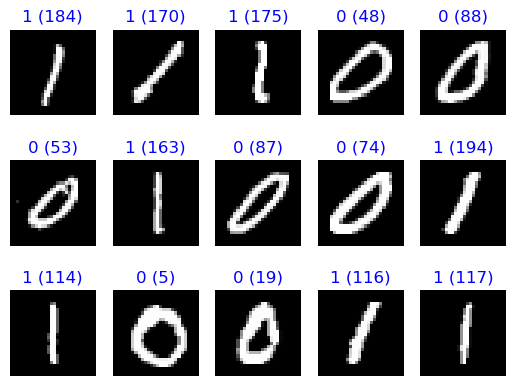

In [69]:
# Show the result with random sampling
random.seed(datetime.now())
index = random.sample(list(range(200)),15)


fig = plt.figure()
for i in range(15):
        plt.subplot(3,5,i+1)
        plt.imshow(imgs_in[:,:,index[i]],"gray")
        plt.axis('off')
        if GT[index[i]] == Pred[index[i]]:
                color="blue"
        else:
                color = "red"
        plt.title(str(int(Pred[index[i]]))+" ("+str(index[i])+")",color=color)
plt.show()

In [70]:
# normalization
X_norm = np.ones((200,9))
X_norm[:,0:8] = X[:,0:8] / np.linalg.norm(X[:,0:8])

# gradient descent
def gradient(epoch = 100000, lr = 0.0003):
    #W = np.zeros((9,1))
    #W = A
    W = np.random.randn(9,1)
    lr = lr
    epoch = epoch
    MSE = np.zeros((epoch,1))
    G = 0
    dW = 0
    for i in range(epoch):
        MSE[i] = np.power((Y-X_norm@W),2).mean()
        G = -((Y-X_norm@W).T @ X_norm / X_norm.shape[0]).T
        dW = -lr*G
        W += dW
    Yp = np.zeros((200,1))
    Yp[X_norm.dot(W) >= 0.5] = 1
    accuracy = (Yp == Y).sum()/Yp.shape[0]
    return W, accuracy, MSE

In [71]:
epoch = 1000
lr = 0.01
while(1):
    for i in range(100):
        if i == 0:
            W, accuracy_W, MSE_W = gradient(epoch, lr)
        else:
            tmp, accuracy_tmp, MSE_tmp = gradient(epoch, lr)
            if accuracy_tmp > accuracy_W:
                W = tmp
                accuracy_W = accuracy_tmp
                MSE_W = MSE_tmp
    break
    if accuracy_W > 0.85:
        break

In [72]:
Yp_gradient=np.zeros((200,1))
Yp_gradient[X_norm.dot(W) >= 0.5] = 1

# Confuse matrix
confuse_matrix = np.zeros((2,2))
confuse_matrix[0,0] = np.sum([Yp_gradient[0:100] == Y[0:100]])
confuse_matrix[1,0] = np.sum([Yp_gradient[0:100] != Y[0:100]])
confuse_matrix[1,1] = np.sum([Yp_gradient[100:200] == Y[100:200]])
confuse_matrix[0,1] = np.sum([Yp_gradient[100:200] != Y[100:200]])
print(confuse_matrix)

[[91.  6.]
 [ 9. 94.]]


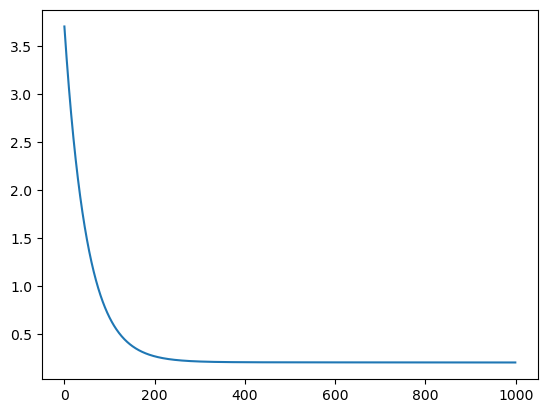

In [73]:
plt.figure()
plt.plot(range(epoch),MSE_W)

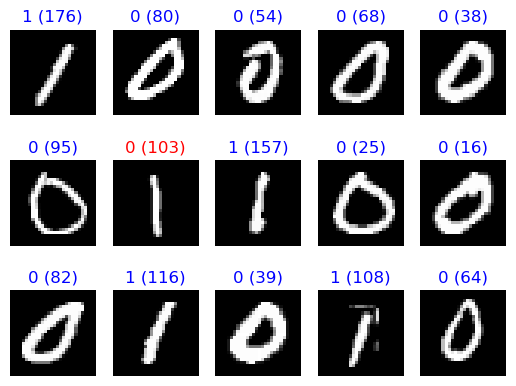

In [74]:
# Show the result with random sampling
random.seed(datetime.now())
index = random.sample(list(range(200)),15)


Pred[Yp_gradient == 0 ] = a
Pred[Yp_gradient == 1 ] = b

fig = plt.figure()
for i in range(15):
        plt.subplot(3,5,i+1)
        plt.imshow(imgs_in[:,:,index[i]],"gray")
        plt.axis('off')
        if GT[index[i]] == Pred[index[i]]:
                color="blue"
        else:
                color = "red"
        plt.title(str(int(Pred[index[i]]))+" ("+str(index[i])+")",color=color)
plt.show()